11493376/11490434 [==============================] - 0s 0us/step


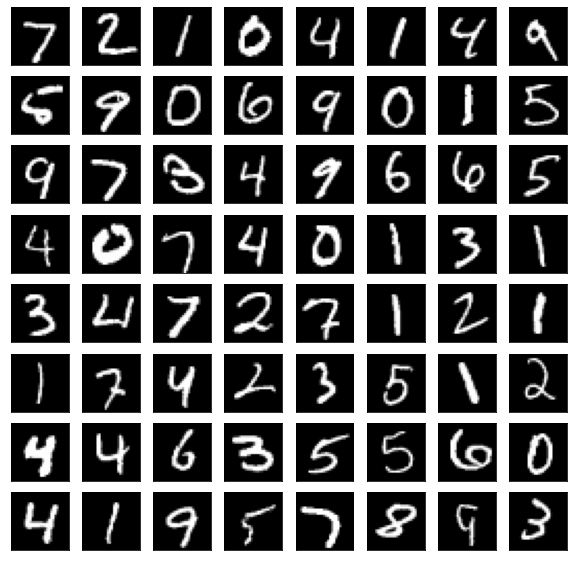

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
dataset = keras.datasets.mnist
(X_raw_train, y_train), (X_raw_test, y_test) = dataset.load_data()
X_train = np.zeros((X_raw_train.shape[0], 108))
X_test = np.zeros((X_raw_test.shape[0], 108))
#applying HOG descriptors to our images to reduce total no of features to evaluate
hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (14, 14), 12)
for n in range(X_raw_train.shape[0]):
    X_train[n] = hog.compute(X_raw_train[n]).reshape(1, -1)
for n in range(X_raw_test.shape[0]):
    X_test[n] = hog.compute(X_raw_test[n]).reshape(1, -1)
#visualize dataset images
_, ax = plt.subplots(8, 8, figsize=(10, 10))
index = 0
for i in range(8):
    for j in range(8):
        cell = ax[i][j]
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False )
        cell.imshow(X_raw_test[index], cmap='gray')
        index += 1
plt.show() 

In [3]:
#calculate priori probabilities
_, prob_y = np.unique(y_train, return_counts=True )
prob_y = prob_y / len(y_train)
num_classes = len(prob_y)
prob_y

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [5]:
#use Gaussian to get the probabilities of each pixel given a class.
#The number of dimensions being very large, the probabilities obtained are very small to
#overcome this we take the log likelihood.
def log_gaussian(X, mu, sigma):
    return -(np.sum(np.log(sigma)) + 0.5 * np.sum(((X - mu) / sigma) ** 2)).reshape(-1,1)

def train_naive_bayes():
    means = np.zeros((num_classes, X_train.shape[1]), dtype=np.float64)
    stdevs = np.zeros((num_classes, X_train.shape[1]), dtype=np.float64)
    for k, y_k in enumerate(np.unique(y_train)):
        indices = np.where(y_k == y_train)
        means[k] = np.mean(X_train[indices], axis=0)
        stdevs[k] = np.std(X_train[indices], axis=0)
    return means, stdevs
#train our model
means, stdevs = train_naive_bayes()
print('Means for class 0:\n ', means[0], '\n\n Standard deviations for class 0\n ', stdevs[
0])

Means for class 0:
  [0.30678743 0.39533906 0.49698065 0.47942126 0.23345504 0.16344804
 0.09279153 0.01742686 0.01565332 0.01517458 0.01731597 0.17423633
 0.44260052 0.43626217 0.43094108 0.29247752 0.06933765 0.05582165
 0.04511124 0.02725237 0.06435403 0.12624306 0.15242024 0.3932381
 0.33039128 0.15454434 0.12076002 0.07976528 0.09248541 0.24739966
 0.29079921 0.26497931 0.36151173 0.36524211 0.31475686 0.3574081
 0.17230083 0.19654137 0.36610455 0.38814007 0.32552076 0.35568275
 0.32603948 0.18848521 0.22032257 0.17830103 0.092407   0.14042486
 0.32399185 0.33429498 0.39768063 0.37237062 0.24249547 0.23246207
 0.18654091 0.0988651  0.13513616 0.15262434 0.13333062 0.26915728
 0.10747293 0.10649556 0.29421138 0.40128702 0.39745421 0.41461391
 0.38427027 0.18927837 0.19220744 0.12930193 0.06576277 0.09647302
 0.27370977 0.08789382 0.09359048 0.11626488 0.10110692 0.23180832
 0.27630185 0.25474979 0.37876405 0.39644995 0.34596988 0.34044592
 0.42185483 0.37627579 0.37949988 0.2662886

In [6]:
def predict(x):
    return np.argmax([np.log(prob_y[k]) + log_gaussian(x.reshape(1, -1), means[k], stdevs[k]) for k in range(num_classes)])

y_pred = np.zeros((X_test.shape[0]))

for n in range(X_test.shape[0]):
    y_pred[n] = predict(X_test[n])
accuracy_score(y_test, y_pred)

0.9151

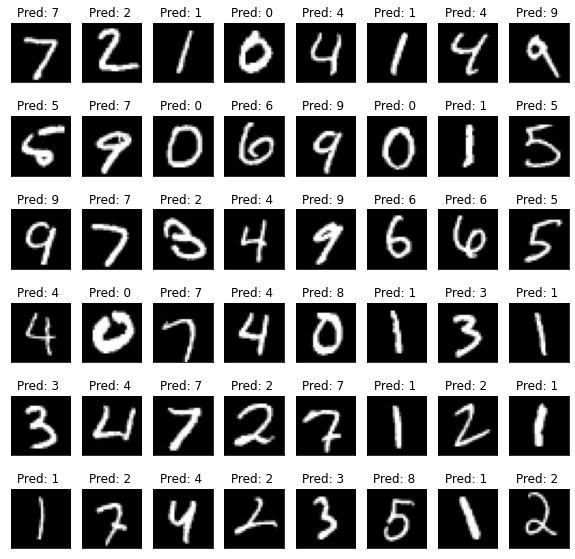

In [7]:
_, ax = plt.subplots(6, 8, figsize=(10, 10))
index = 0
for i in range(6):
    for j in range(8):
        cell = ax[i][j]
        cell.set_title('Pred: %s ' % predict(X_test[index]))
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False )
        cell.imshow(X_raw_test[index], cmap='gray')
        index += 1
plt.show()

In [9]:
!pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.0-cp36-none-any.whl size=38869 sha256=135b0b32b12f1aa0231a7ddb8a472bfe06cd150dea19b01c40591858bb173ba3
  Stored in directory: /root/.cache/pip/wheels/43/48/64/27ce763bcda2bd95d04e71ac95a22bdd286e7ab98269cf1f68
Successfully built pybbn


1. Create a Bayesian network in pybbn representing the joint probability distribution above.

In [10]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
a = BbnNode(Variable(0, 'disease', ['none', 'influenza','ebola']), [0.9, 0.08,0.02])
b = BbnNode(Variable(1, 'fever', ['true', 'false']), [0.01, 0.99, 0.98, 0.02,0.99,0.01])
c = BbnNode(Variable(2, 'cough', ['true', 'false']), [0.01, 0.99, 0.95, 0.05,0.1,0.9])
d = BbnNode(Variable(3, 'diarrhoea', ['true', 'false']), [0.05, 0.95, 0.2, 0.8,0.98,0.02
])
#1. Create Bayesian network
bbn = Bbn() \
    .add_node(a) \
    .add_node(b) \
    .add_node(c) \
    .add_node(d) \
    .add_edge(Edge(a, b, EdgeType.DIRECTED)) \
    .add_edge(Edge(a, c, EdgeType.DIRECTED)) \
    .add_edge(Edge(a, d, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)
#Printed marginal probabilties for all symptoms
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)

0|disease|none,influenza,ebola
0=none|0.90000
0=influenza|0.08000
0=ebola|0.02000
1|fever|true,false
1=true|0.10720
1=false|0.89280
2|cough|true,false
2=true|0.08700
2=false|0.91300
3|diarrhoea|true,false
3=true|0.08060
3=false|0.91940


In [11]:
!pip install pgmpy

     |████████████████████████████████| 327kB 5.2MB/s 


2.Create full joint probability distribution table

In [14]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
model = BayesianModel([('Disease', 'Fever'), ('Disease', 'Cough'), ('Disease', 'Diarrhoea')])

cpd_d = TabularCPD(variable='Disease', variable_card=3, 
                   values=[[0.9], [0.08],[0.02]])

cpd_f = TabularCPD(variable='Fever', variable_card=2,
                   values=[[0.01, 0.98, 0.99],
                   [0.99, 0.02, 0.01]],
                   evidence=['Disease'],
                   evidence_card=[3])

cpd_c = TabularCPD(variable='Cough', variable_card=2,
                   values=[[0.01, 0.95, 0.1],
                   [0.99, 0.05, 0.9]],
                   evidence=['Disease'],
                   evidence_card=[3])

cpd_dr = TabularCPD(variable='Diarrhoea', variable_card=2,
                    values=[[0.05, 0.2, 0.98],
                    [0.95, 0.8, 0.02]],
                    evidence=['Disease'],
                    evidence_card=[3])

model.add_cpds(cpd_d, cpd_f, cpd_c, cpd_dr)
model.check_model()
model.get_cpds()

(Fever _|_ Diarrhoea, Cough | Disease)
(Cough _|_ Fever, Diarrhoea | Disease)
(Diarrhoea _|_ Fever, Cough | Disease)

In [15]:
model.local_independencies(['Disease', 'Fever', 'Cough', 'Diarrhoea'])

(Fever _|_ Diarrhoea, Cough | Disease)
(Cough _|_ Fever, Diarrhoea | Disease)
(Diarrhoea _|_ Fever, Cough | Disease)

3.Calculate P(Disease=Influenza|Fever=true,Cough=true,Diarrhea=true)

In [16]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
print(infer.query (['Disease'],{'Cough': 0,'Fever': 0,'Diarrhoea': 0}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+------------+----------------+
| Disease    |   phi(Disease) |
+============+================+
| Disease(0) |         0.0003 |
+------------+----------------+
| Disease(1) |         0.8845 |
+------------+----------------+
| Disease(2) |         0.1152 |
+------------+----------------+


4.Calculate P(Fever=true|Cough=true,Diarrhea=true)

In [17]:
print(infer.query (['Fever'],{'Cough': 0,'Diarrhoea': 0}))

Eliminating: Disease: 100%|██████████| 1/1 [00:00<00:00, 247.51it/s]

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(0) |       0.9563 |
+----------+--------------+
| Fever(1) |       0.0437 |
+----------+--------------+
